<a href="https://colab.research.google.com/github/podobongbong/the_project/blob/main/Nov9_Multi_var_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/podobongbong/the_project.git
import os
os.chdir('/content/the_project')
import pandas as pd


fatal: destination path 'the_project' already exists and is not an empty directory.


In [2]:
seoul = pd.read_csv('seoul_08.csv')
busan = pd.read_csv('busan_08.csv')

In [3]:

import tensorflow as tf
import numpy as np
import random

# 시드 고정
seed = 2024
tf.random.set_seed(seed)         # TensorFlow 시드 고정
np.random.seed(seed)             # NumPy 시드 고정
random.seed(seed)                # Python 시드 고정

#%% DATA PREP
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Seoul Scalers
scaler_energy_seoul = MinMaxScaler()
scaler_population_seoul = MinMaxScaler()
scaler_climate_seoul = MinMaxScaler()
# Busan Scalers
scaler_energy_busan = MinMaxScaler()
scaler_population_busan = MinMaxScaler()
scaler_climate_busan = MinMaxScaler()


# Normalize Seoul data (energy, pop, climate)
seoul_energy_scaled = scaler_energy_seoul.fit_transform(seoul['energy'].values.flatten().reshape(-1, 1))
seoul_population_scaled = scaler_population_seoul.fit_transform(seoul['pop'].values.flatten().reshape(-1, 1))
seoul_climate_scaled = scaler_climate_seoul.fit_transform(seoul['climate_summary'].values.flatten().reshape(-1, 1))

# Normalize Busan data (energy, pop, climate)
busan_energy_scaled = scaler_energy_busan.fit_transform(busan['energy'].values.flatten().reshape(-1, 1))
busan_population_scaled = scaler_population_busan.fit_transform(busan['pop'].values.flatten().reshape(-1, 1))
busan_climate_scaled = scaler_climate_busan.fit_transform(busan['climate_summary'].values.flatten().reshape(-1, 1))



In [4]:
#%% SLIDING WINDOW
#%% Create Sliding Windows
def create_sliding_window_multi(data_energy, data_population, data_climate, window_size):
    X, y = [], []
    for i in range(window_size, len(data_energy)):
        X.append(np.column_stack((data_energy[i-window_size:i], data_population[i-window_size:i],data_climate[i-window_size:i])))
        y.append(data_energy[i])  # Next month's energy consumption
    return np.array(X), np.array(y)

WINDOW_SIZE = 12
feature_number = 3 #energy, population, climate

# Create sliding window samples for Seoul and Busan
X_seoul, y_seoul = create_sliding_window_multi(seoul_energy_scaled, seoul_population_scaled, seoul_climate_scaled, WINDOW_SIZE)
X_busan, y_busan = create_sliding_window_multi(busan_energy_scaled, busan_population_scaled, busan_climate_scaled, WINDOW_SIZE)

# Split Busan data into training and test sets (hold out the last 12 months for testing)
X_train_busan = X_busan[:-12]
y_train_busan = y_busan[:-12]
X_test_busan = X_busan[-12:]
y_test_busan = y_busan[-12:]


In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, BatchNormalization, Reshape
import matplotlib.pyplot as plt
WINDOW_SIZE = 12
feature_number = 3

## Step 1: Pre-trained Model for Feature Extraction on Seoul's Data
# Building and compiling the pre-trained model
input_layer = Input(shape=(WINDOW_SIZE, feature_number), name='Input')
lstm_out = LSTM(64, activation='tanh', name='LSTM_Layer')(input_layer)
dense_1 = Dense(32, activation='relu', name='Dense_1')(lstm_out)
dense_2 = Dense(16, activation='relu', name='Dense_2')(dense_1)
output_layer = Dense(1, activation='linear', name='Output')(dense_2)

pretrained_model = Model(inputs=input_layer, outputs=output_layer)
pretrained_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Pretrain on Seoul's data
print("Pretraining on Seoul's data...")
history_pretrain = pretrained_model.fit(X_seoul, y_seoul, epochs=100, batch_size=16, validation_split=0.2)

# Freeze the LSTM layer in the pre-trained model for feature extraction
pretrained_model.get_layer('LSTM_Layer').trainable = False

# Create a model for feature extraction from the LSTM layer's output
feature_extractor = Model(inputs=pretrained_model.input, outputs=pretrained_model.get_layer('LSTM_Layer').output)

# Generate extracted features for Busan's training and test data
X_train_features_busan = feature_extractor.predict(X_train_busan)
X_test_features_busan = feature_extractor.predict(X_test_busan)



Pretraining on Seoul's data...
Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 291ms/step - loss: 0.0579 - mae: 0.1888 - val_loss: 0.1043 - val_mae: 0.2305
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - loss: 0.0241 - mae: 0.1064 - val_loss: 0.0758 - val_mae: 0.1711
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - loss: 0.0218 - mae: 0.1042 - val_loss: 0.0841 - val_mae: 0.1873
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0217 - mae: 0.0977 - val_loss: 0.0772 - val_mae: 0.1739
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0207 - mae: 0.0977 - val_loss: 0.0693 - val_mae: 0.1642
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0201 - mae: 0.0972 - val_loss: 0.0692 - val_mae: 0.1643
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0200 - mae: 0.0957 - val_loss: 0.0660 - val_mae: 0.1616
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0197 - mae: 0.0959 - val_loss: 0.0628 - val_mae: 0.1594
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9

In [6]:

## Step 2: Build a New Model for Fine-Tuning on Busan's Data
# New model input layer
input_features_layer = Input(shape=(X_train_features_busan.shape[1],), name='Input_Features')
reshaped_input = Reshape((1, X_train_features_busan.shape[1]))(input_features_layer)  # Reshape to (batch_size, time_steps=1, features)

# New LSTM layer for fine-tuning
lstm_new = LSTM(32, activation='tanh', name='LSTM_New')(reshaped_input)

# Add dense layers with batch normalization for better training
dense_new_1 = Dense(32, activation='relu', name='Dense_New_1')(lstm_new)
batch_norm_1 = BatchNormalization(name='Batch_Norm_1')(dense_new_1)
dense_new_2 = Dense(16, activation='relu', name='Dense_New_2')(batch_norm_1)
batch_norm_2 = BatchNormalization(name='Batch_Norm_2')(dense_new_2)

# Final output layer
output_new_layer = Dense(1, activation='linear', name='Output')(batch_norm_2)

# Combine into new model
new_model = Model(inputs=input_features_layer, outputs=output_new_layer)
new_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the new model with extracted features for Busan's data
print("Training new layers on Busan's data...")
history_finetune = new_model.fit(X_train_features_busan, y_train_busan, epochs=100, batch_size=32, validation_split=0.2)


Training new layers on Busan's data...
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 261ms/step - loss: 1.3718 - mae: 0.9495 - val_loss: 0.1271 - val_mae: 0.3031
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.3309 - mae: 0.4471 - val_loss: 0.1099 - val_mae: 0.2706
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1212 - mae: 0.2750 - val_loss: 0.0990 - val_mae: 0.2467
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1083 - mae: 0.2437 - val_loss: 0.0893 - val_mae: 0.2249
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0652 - mae: 0.2039 - val_loss: 0.0806 - val_mae: 0.2049
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0461 - mae: 0.1676 - val_loss: 0.0752 - val_mae: 0.1928
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0331 - mae: 0.1439 - val_loss: 0.0706 - val_mae: 0.1843
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0284 - mae: 0.1360 - val_loss: 0.0679 - val_mae: 0.1797
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━

Evaluating on Busan's test data...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1244 - mae: 0.3222
Test Loss: 0.12440326809883118, Test MAE: 0.3222029209136963
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


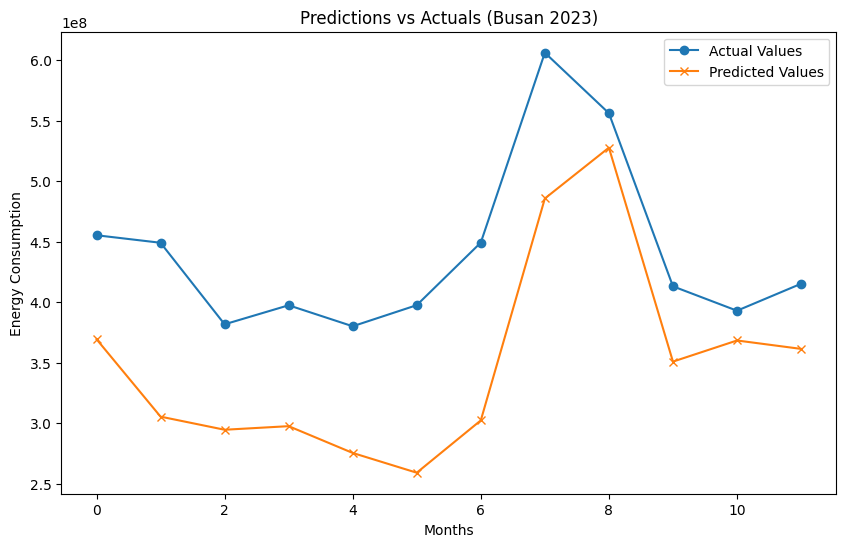

In [7]:

## Step 3: Evaluation and Prediction on Busan's Test Data
print("Evaluating on Busan's test data...")
test_loss, test_mae = new_model.evaluate(X_test_features_busan, y_test_busan)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# Predict on test data
predictions = new_model.predict(X_test_features_busan)

# Rescale predictions and actual values back to the original scale for interpretation
predictions_rescaled = scaler_energy_busan.inverse_transform(predictions.reshape(-1, 1)).flatten()
actual_rescaled = scaler_energy_busan.inverse_transform(y_test_busan.reshape(-1, 1)).flatten()

# Visualization of Prediction Results
def plot_predictions(y_true, y_pred, title='Predictions vs Actuals (Busan 2023)'):
    plt.figure(figsize=(10, 6))
    plt.plot(y_true, label='Actual Values', marker='o')
    plt.plot(y_pred, label='Predicted Values', marker='x')
    plt.title(title)
    plt.xlabel('Months')
    plt.ylabel('Energy Consumption')
    plt.legend()
    plt.show()

plot_predictions(actual_rescaled, predictions_rescaled)

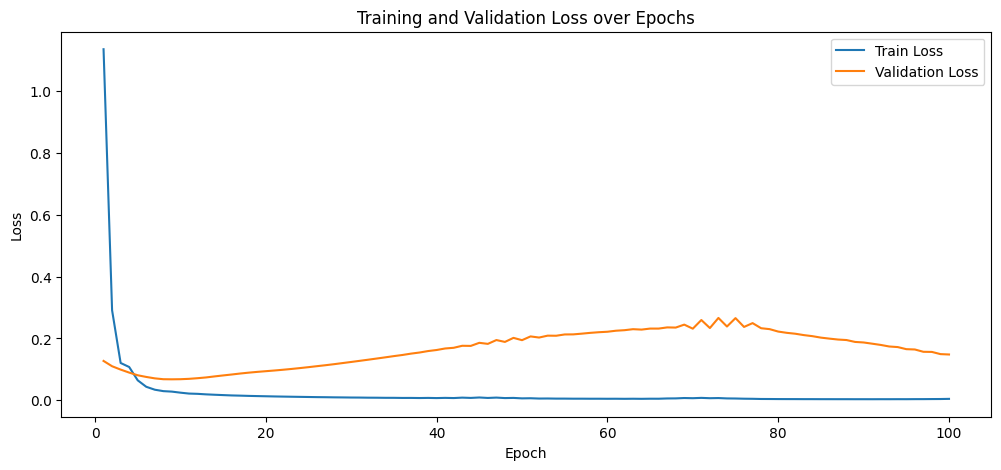

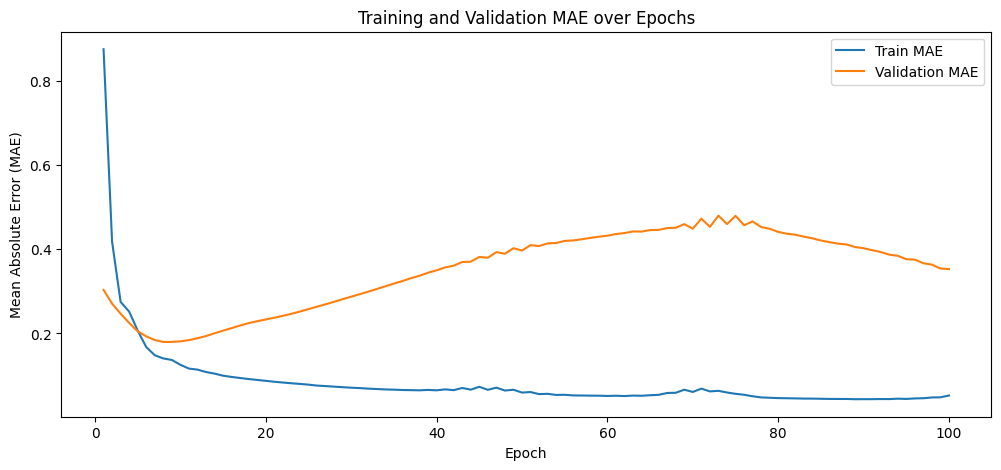

In [8]:

epochs = range(1, len(history_finetune.history['loss']) + 1)

# Loss
plt.figure(figsize=(12, 5))
plt.plot(epochs, history_finetune.history['loss'], label='Train Loss')
plt.plot(epochs, history_finetune.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train Loss', 'Validation Loss'])
plt.title('Training and Validation Loss over Epochs')
plt.show()

# MAE
plt.figure(figsize=(12, 5))
plt.plot(epochs, history_finetune.history['mae'], label='Train MAE')
plt.plot(epochs, history_finetune.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend(['Train MAE', 'Validation MAE'])
plt.title('Training and Validation MAE over Epochs')
plt.show()
